# Test 1 & 2: Cholesky CPU

These test capture the runtime for the Cholesky decomposition with GPRat on the CPU.
We use a fixed problem size of $32768=2^{15}$, an increasing number of tiles in $\{1,2,4,8,16,32,64,128,256,512\}$, an increasing number of cores in $\{6,12,24,48\}$, 8 regressors and loop 10 times.
Note that we do not account for the time it takes to return the data to the callee.

Findings:

- There is no optimal number of cores. Therefore, we will use 48 cores for the other tests.
- ...

In [26]:
# setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.cm import viridis
from matplotlib.colors import Normalize
import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams.update({'font.size': 11})
mpl.rcParams.update({'errorbar.capsize': 5})

In [124]:
# load data

apex_dir_cholesky = "./data/2" # TODO: set to 1
apex_dir_steps = "./data/2"

names_cholesky = [
    "cholesky"
]

names_steps = [
    "cholesky_step assembly",
    "cholesky_step cholesky",
    "assemble K_tiles",
    "cholesky potrf",
    "cholesky trsm",
    "cholesky syrk",
    "cholesky gemm",
]

file_headers = [
    "n_cores",
    "n_train",
    "n_tiles",
    "n_reg",
    "n_loops"
]

def apex_files_to_df(dir, names):
    data = []
    for filename in os.listdir(dir):
        if filename.endswith(".csv"):
            parts = filename.replace("apex_profiles_", "").replace(".csv", "").split("_")
            file_params = dict(zip(file_headers, map(int, parts)))
            file_path = os.path.join(dir, filename)
            df = pd.read_csv(file_path)
            df = df[df['name'].isin(names)]
            for key, value in file_params.items():
                df[key] = value
            data.append(df)
    df_combined = pd.concat(data, ignore_index=True)
    df_combined = df_combined.sort_values(by='n_tiles')
    return df_combined

df_cholesky = apex_files_to_df(apex_dir_cholesky, names_cholesky)
df_steps = apex_files_to_df(apex_dir_steps, names_steps)

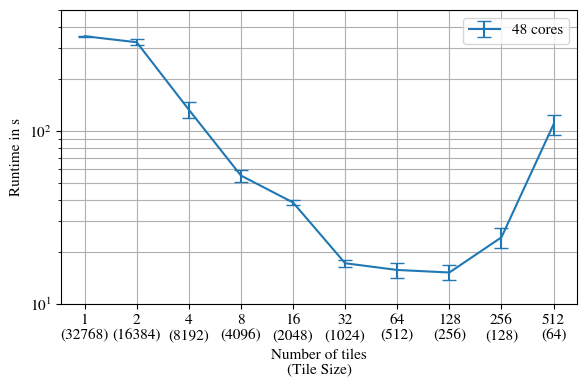

In [123]:
# plot for cholesky

n_train = 32768

plt.figure(figsize=(6, 4))

plt.xlabel('Number of tiles\n(Tile Size)')
plt.ylabel('Runtime in s')
plt.grid(True, which="both")
plt.xscale('log', base=2)
plt.yscale("log", base=10)
plt.ylim(10,500)

xticks = df_cholesky['n_tiles'].unique()
tile_sizes = n_train / xticks
plt.xticks(
    xticks,
    [f"{int(tile)}\n({int(size)})" for tile, size in zip(xticks, tile_sizes)],
)

for n_cores, group in df_cholesky.groupby("n_cores"):
    plt.errorbar(group['n_tiles'], group['mean']/10**9, yerr=2*group["stddev"]/10**9, label=f"{n_cores} cores")

plt.legend()
plt.tight_layout()
plt.savefig("./pdf/cholesky-cpu.pdf")

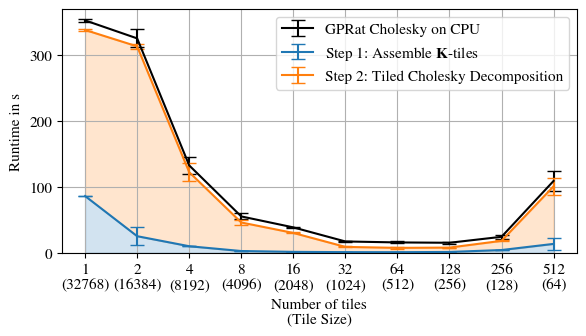

In [117]:
# plot for cholesky steps

n_train = 32768
n_cores = 48

plt.figure(figsize=(6, 3.5))

plt.xlabel("Number of tiles\n(Tile Size)")
plt.ylabel("Runtime in s")
plt.grid(True, which="both")
plt.ylim(0, 370)
plt.xscale("log", base=2)
# plt.yscale("log", base=10)

xticks = df_steps["n_tiles"].unique()
tile_sizes = n_train / xticks
plt.xticks(
    xticks,
    [f"{int(tile)}\n({int(size)})" for tile, size in zip(xticks, tile_sizes)],
)

for name, group in df_cholesky.groupby("name"):
    plt.errorbar(
        group["n_tiles"],
        group["mean"] / 10**9,
        yerr=2*group["stddev"] / 10**9,
        color="black",
        label="GPRat Cholesky on CPU"
    )

names = [
    "cholesky_step assembly",
    "cholesky_step cholesky",
]
legend = [
    r"Step 1: Assemble $\mathbf{K}$-tiles",
    f"Step 2: Tiled Cholesky Decomposition",
]
colors = [
    "tab:blue",
    "tab:orange",
]

df_accum = pd.DataFrame({
    'n_tiles': df_steps['n_tiles'].unique(),
    'mean': 0
})
df_prior = df_accum.copy()
for name, label, color in zip(names, legend, colors):
    df_name = df_steps[df_steps["name"] == name]
    df_accum["mean"] += df_name["mean"].values
    plt.errorbar(
        df_name["n_tiles"],
        df_accum["mean"] / 10**9,
        yerr=2*df_name["stddev"] / 10**9,
        label=label,
        color=color
    )
    plt.fill_between(
        df_name["n_tiles"],
        df_prior["mean"] / 10**9,
        df_accum["mean"] / 10**9,
        color=color,
        alpha=0.2,
    )
    df_prior = df_accum.copy()

plt.legend()
plt.tight_layout()
plt.savefig("./pdf/cholesky-cpu-steps.pdf")

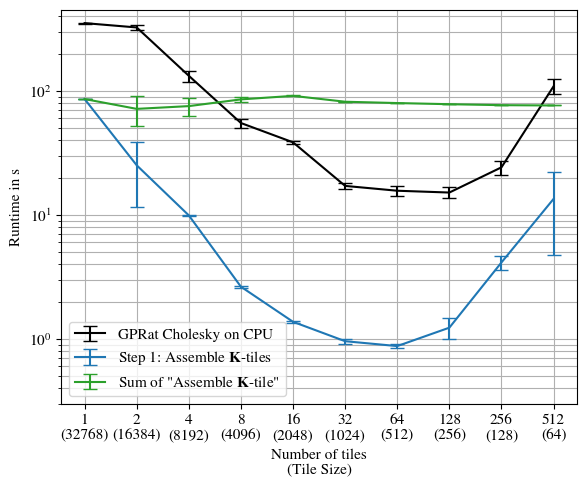

In [119]:
# plot for cholesky: Assembly

n_train = 32768
n_cores = 48

plt.figure(figsize=(6, 5))

plt.xlabel("Number of tiles\n(Tile Size)")
plt.ylabel("Runtime in s")
plt.grid(True, which="both")
plt.xscale("log", base=2)
plt.yscale("log", base=10)
plt.ylim(0.3, 450)

xticks = df_cholesky["n_tiles"].unique()
tile_sizes = n_train / xticks
plt.xticks(
    xticks,
    [f"{int(tile)}\n({int(size)})" for tile, size in zip(xticks, tile_sizes)],
)

for name, group in df_cholesky.groupby("name"):
    plt.errorbar(
        group["n_tiles"],
        group["mean"] / 10**9,
        yerr=2 * group["stddev"] / 10**9,
        color="black",
        label="GPRat Cholesky on CPU",
    )

df_step_assembly = df_steps[df_steps["name"] == "cholesky_step assembly"]
plt.errorbar(
    df_step_assembly["n_tiles"],
    df_step_assembly["mean"] / 10**9,
    yerr=2 * df_step_assembly["stddev"] / 10**9,
    label=r"Step 1: Assemble $\mathbf{K}$-tiles",
)


names_blas = [
    "assemble K_tiles",
]
names_steps_legend = [
    "Assemble tiles",
]

for i, (name, legend_name) in enumerate(zip(names_blas, names_steps_legend)):
    df_name = df_steps[df_steps["name"] == name]
    df_err = 2 * np.sqrt((df_name["stddev"] / 10**9) ** 2 * df_name["num samples/calls"] / 10)
    plt.errorbar(
        df_name["n_tiles"],
        df_name["mean"] / 10**9 * df_name["num samples/calls"] / 10,
        yerr=df_err,
        label=r'Sum of "Assemble $\mathbf{K}$-tile"',
        color="tab:green",
    )

plt.legend()
plt.tight_layout()
plt.savefig("./pdf/cholesky-cpu-assembly.pdf")

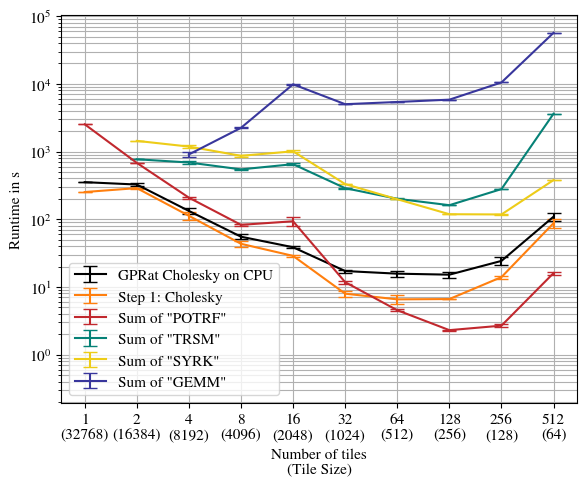

In [120]:
# plot for cholesky BLAS

n_train = 32768
n_cores = 48

plt.figure(figsize=(6, 5))

plt.xlabel("Number of tiles\n(Tile Size)")
plt.ylabel("Runtime in s")
plt.grid(True, which="both")
plt.xscale("log", base=2)
plt.yscale("log", base=10)
# plt.ylim(0, 370)

xticks = df_cholesky["n_tiles"].unique()
tile_sizes = n_train / xticks
plt.xticks(
    xticks,
    [f"{int(tile)}\n({int(size)})" for tile, size in zip(xticks, tile_sizes)],
)

for name, group in df_cholesky.groupby("name"):
    plt.errorbar(
        group["n_tiles"],
        group["mean"] / 10**9,
        yerr=2 * group["stddev"] / 10**9,
        color="black",
        label="GPRat Cholesky on CPU",
    )

names_steps = [
    "cholesky_step cholesky",
]
names_steps_legend = [
    "Cholesky",
]

for i, (name, legend_name) in enumerate(zip(names_steps, names_steps_legend)):
    plt.errorbar(
        df_steps[df_steps["name"] == name]["n_tiles"],
        df_steps[df_steps["name"] == name]["mean"] / 10**9,
        yerr=2 * df_steps[df_steps["name"] == name]["stddev"] / 10**9,
        label=f"Step {i+1}: {legend_name}",
        color="tab:orange",
    )

names_blas = [
    "cholesky potrf",
    "cholesky trsm",
    "cholesky syrk",
    "cholesky gemm",
]
names_steps_legend = [
    'Sum of "POTRF"',
    'Sum of "TRSM"',
    'Sum of "SYRK"',
    'Sum of "GEMM"',
]
colors = [
    "#c1282e",
    "#068176",
    "#edcc18",
    "#38369c",
]

for name, legend_name, color in zip(names_blas, names_steps_legend, colors):
    plt.errorbar(
        df_steps[df_steps["name"] == name]["n_tiles"],
        df_steps[df_steps["name"] == name]["mean"]
        / 10**9
        * df_steps[df_steps["name"] == name]["num samples/calls"],
        yerr=2
        * np.sqrt(
            (df_steps[df_steps["name"] == name]["stddev"] / 10**9) ** 2
            * df_steps[df_steps["name"] == name]["num samples/calls"]
        ),
        label=f"{legend_name}",
        color=color,
    )

plt.legend()
plt.tight_layout()
plt.savefig("./pdf/cholesky-cpu-blas.pdf")